<a href="https://colab.research.google.com/github/Grubes2023/403_team_29/blob/main/Machine_learning/Disaster_model_v0_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle

import tensorflow as tf
from keras.optimizers import Adam, RMSprop
from keras.models import Model, load_model
from keras.layers import Embedding, LSTM, Dense, Dropout, Input, Activation
from keras.callbacks import EarlyStopping
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

mounted = False

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

mounted = True

Mounted at /content/gdrive


In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
# !pip install pyyaml h5py  # Required to save models in HDF5 format

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
#creating a function to prepocess tweet
def data_processing(tweet):
    tweet = tweet.lower()                                                         # Make tweet lowercase for consistency
    tweet = re.sub(r"https\S+|www\S+http\S+", '', tweet, flags = re.MULTILINE)    # get rid of any websites in tweet

    tweet = re.sub(r'\@w+|\#','', tweet)                                        
    tweet = re.sub(r'[^\w\s]','',tweet)
    tweet = re.sub(r'ð','',tweet)  
    return tweet

# time to get the stem (lemma) of each word in the tweet
lemmatizer = WordNetLemmatizer()
def lemmatizing(data):
    # split string into list of words
    word_list = data.split()
    # lemmatize each word in the list
    word_list = [lemmatizer.lemmatize(word) for word in word_list]
    # combine the list into 1 string and return that string
    tweet = ' '.join(word_list)
    return tweet

Main Drive Dataset Loaded



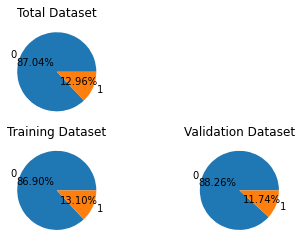

In [21]:
# getting my dataset for training
if mounted:
    try:
        # main csv will be in personal drive. if not go to a backup file
        tweet_df = pd.read_csv('/content/gdrive/MyDrive/Datasets_for_403/disaster_training_binary.csv')
        print("Main Drive Dataset Loaded\n")
    except:
        # backup file is in shared folder
        tweet_df = pd.read_csv('/content/gdrive/Shareddrives/ECEN 403 Group 29/Brandon_ML_files/disaster_training_binary.csv')
        print("Backup Drive Dataset Loaded\n")
else:
    # ultimate backup on local machine
    tweet_df = pd.read_csv('disaster_training_binary.csv')

# apply proprocessing function to tweets and save as itself
tweet_df.tweet = tweet_df['tweet'].astype(str)
tweet_df.tweet = tweet_df['tweet'].apply(data_processing)
# get rid of any duplicate tweets and save as itself
tweet_df = tweet_df.drop_duplicates('tweet')

# lemmatize all the tweets
tweet_df.tweet = tweet_df['tweet'].apply(lambda x: lemmatizing(x))    # apply lemmatizer

my_random_state = 42
# tweet_df = shuffle(tweet_df, random_state=my_random_state)

## up and downsampling tweets
# class_2 = tweet_df[tweet_df['label'] == 2]
class_1 = tweet_df[tweet_df['label'] == 1]
class_0 = tweet_df[tweet_df['label'] == 0]  #.sample(n=1000)

shuffled_df = shuffle(pd.concat([class_1, class_0], axis=0), random_state=my_random_state)

# getting data into training and testing sets
features = shuffled_df['tweet']
labels = shuffled_df['label']
X_train, X_val, Y_train, Y_val = train_test_split(features,
                                                  labels,
                                                  test_size=0.1,
                                                  random_state=my_random_state)

# Visualizing the Data
plt.subplot(2,2,1)
plt.pie(shuffled_df['label'].value_counts().values,
        labels = shuffled_df['label'].value_counts().index.astype(int),
        autopct='%1.2f%%',
        wedgeprops = {'linewidth': 1})
plt.title('Total Dataset')

plt.subplot(2,2,3)
plt.pie(Y_train.value_counts().values,
        labels = Y_train.value_counts().index.astype(int),
        autopct='%1.2f%%',
        wedgeprops = {'linewidth': 1})
plt.title('Training Dataset')

plt.subplot(2,2,4)
plt.pie(Y_val.value_counts().values,
        labels = Y_val.value_counts().index.astype(int),
        autopct='%1.2f%%',
        wedgeprops = {'linewidth': 1})
plt.title('Validation Dataset')

plt.show()

In [19]:
#########################
## My model parameters ##
#########################
VOCAB_SIZE = 6400
MAX_LEN = 250

# create a tokenizer to tokenize the text (words -> numbers)
tok = Tokenizer(num_words=VOCAB_SIZE)
tok.fit_on_texts(X_train)

# apply tokenizer to tweets and pad sequences tget everything the same length
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences, maxlen=MAX_LEN)

# apply tokenizer and pad sequences to validation data
val_sequences = tok.texts_to_sequences(X_val)
val_sequences_matrix = pad_sequences(val_sequences, maxlen=MAX_LEN)


#############
### MODEL ###
#############
def RNN():
    inputs = Input(name='inputs',shape=[MAX_LEN])
    layer = Embedding(VOCAB_SIZE,50,input_length=MAX_LEN)(inputs)

    # adding a Long-Short term memory layer. This is kinda the NLP part of model
    layer = LSTM(512)(layer)

    # adding a dense/activation/dropout block
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)

    # adding a second dense/activation/dropout block
    layer = Dense(512,name='FC2')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.25)(layer)

    # adding the final output layer
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)

    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()

# my optimizers: probably gonna use Adam, but different example of NLP have RMSprop
my_optimizers =[
                Adam(), 
                RMSprop()
               ]

# loss functions : binary = ([0],[1])
#                       for categ/sparse_categ - last activation layer must be softmax
#                  categ = ([1,0,0], [0,1,0], [0,0,1])  need to pair with argmax i think
#                  sparse_categ = ([0], [1], [2])
loss_fns =[
           'binary_crossentropy',
           'categorical_crossentropy',
           'sparse_categorical_crossentropy'
          ]

# compile the model (does NOT do any training or predicting)
model.compile(loss=loss_fns[0],optimizer=Adam(), metrics=['accuracy'])

# print out a summary of the model (gives number of trainable parameters)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 250)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 250, 50)           320000    
                                                                 
 lstm_5 (LSTM)               (None, 512)               1153024   
                                                                 
 FC1 (Dense)                 (None, 256)               131328    
                                                                 
 activation_15 (Activation)  (None, 256)               0         
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 FC2 (Dense)                 (None, 512)               1315

In [20]:
# callback to stop training if starting to overtrain
ES_callback = EarlyStopping(monitor='loss', min_delta=0.0001, start_from_epoch=5, mode='max', restore_best_weights=True, patience=2)

# TRAINING
model.trainable = True
model.fit(sequences_matrix,Y_train,
          batch_size=128,epochs=10,
          validation_data=(val_sequences_matrix, Y_val),
          verbose=1,
          callbacks=[ES_callback])
model.trainable = False


Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 0.4594 - accuracy: 0.8605

KeyboardInterrupt: ignored

In [91]:
# making sure we dont change model during testing
model.trainable = False

test_tweets =[
              ["a semi truck crashed on the highway",0],
              ["Love the new bbq pit. Gets good and hot, and smokes brisket like no other",0],
              ["the fire near the power plant is hot", 1],
              ["heavy winds on the way to dallas", 1], 
              ["Breaking: incoming rain", 0],
              ["this concert is fire", 0],
              ["a violent storm is coming into town tommorow", 1],
             ]

# NOTES FROM TESTING
"""
need to break connection between 'BREAKING' and label 1
need some example of rain in label 0
need some highway crash examples in label 0
need something to connect disaster near a power plant to label 1/2
need some more violent storm examples of label 1
"""

new_tweets = []
true_labels = []
pred_preds = []
for i in range(len(test_tweets)):
    new_tweets.append(test_tweets[i][0])
    true_labels.append(test_tweets[i][1])

seq = tok.texts_to_sequences(new_tweets)
padded = pad_sequences(seq, maxlen=MAX_LEN)
pred = model.predict(padded).squeeze()

categories = {0 : "No Concern",
              1 : "Of Moderate Concern",
              2 : "An Immediate Threat"}

for i in range(len(new_tweets)):
    print(new_tweets[i])
    print("Raw Output of Model : ", np.around(pred[i], decimals=3))
    prediction = np.around(pred[i]).astype(int)
    pred_preds.append(prediction)
    print("Predicted: ", categories[prediction], '\n')

1/1 [==============================] - 0s 23ms/step
a semi truck crashed on the highway
Raw Output of Model :  nan


KeyError: ignored

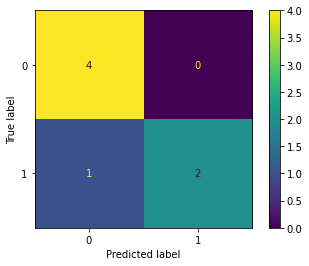

In [56]:
ConfusionMatrixDisplay(confusion_matrix(true_labels, pred_preds)).plot()

In [ ]:
### Saving a Model ###

# !mkdir -p '/content/gdrive/MyDrive/403_saved_models'

model_version = '0.2'

model.save('/content/gdrive/MyDrive/403_saved_models/model_' + str(model_version)) 

In [ ]:
### Loading a Saved Model ###
loaded_model = load_model('/content/gdrive/MyDrive/403_saved_models/model_'+ str(model_version))

# make sure I dont screw with the weights and biases
loaded_model.trainable = False

# Check its architecture
loaded_model.summary()